In [1]:
!pip install tensorflow==2

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # For y values
from tensorflow.keras.models import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt

import seaborn as sns; sns.set()


In [3]:
np.random.seed(123)  # for reproducibility

## Some Helping Functions

In [4]:
def print_heatmap(data):
    heatmap = sns.heatmap(data)
    heatmap.set(xlabel='Pseudorapidity', ylabel='Azimuthal Angle')
    print(heatmap)
    #plt.imshow(data, cmap='jet', interpolation='nearest')
    #plt.show()

In [6]:
def get_predicted_values(output_values):
    predicted_values = []
    for probability in output_values:
        if probability[0] > probability[1]:
            predicted_values.append(0)
        else:
            predicted_values.append(1)
    return predicted_values

# Reading the data

First we read the Signal Data and produce a heatmap from the average of all lines. We do so, in order to get the feeling of what our data looks like.

In [7]:
! wget -c https://github.com/raphaelmcobe/jet-classification/raw/master/signal_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt

--2020-02-20 15:31:35--  https://github.com/raphaelmcobe/jet-classification/raw/master/signal_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt
Resolvendo github.com (github.com)... 18.228.67.229
Conectando-se a github.com (github.com)|18.228.67.229|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 302 Found
Localização: https://raw.githubusercontent.com/raphaelmcobe/jet-classification/master/signal_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt [redirecionando]
--2020-02-20 15:31:36--  https://raw.githubusercontent.com/raphaelmcobe/jet-classification/master/signal_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt
Resolvendo raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.252.133
Conectando-se a raw.githubusercontent.com (raw.githubusercontent.com)|151.101.252.133|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 416 Range Not Satisfiable

    O arquivo já foi completamente obtido; não há nada a ser feito.



In [8]:
!ls -lh

total 510M
-rw-rw-r-- 1 hub hub  10M fev  6 15:29 '[Aapo_Hyvarinen,_Juha_Karhunen,_Erkki_Oja]_Indepen(z-lib.org).pdf'
-rw-r--r-- 1 hub hub  88M fev 19 16:06  background_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt
-rw-rw-r-- 1 hub hub 4,6M fev  6 15:29 '[Christopher_M._Bishop]_Pattern_Recognition_and_Ma(z-lib.org).pdf'
-rw-rw-r-- 1 hub hub  61M fev 13 14:37  google-chrome-stable_current_amd64.deb
-rw-r--r-- 1 hub hub 137K fev 19 17:45 'Image_Jet_Tagging_Analysis_(PTJ_250_300)-Copy1.ipynb'
-rw-rw-r-- 1 hub hub 160K fev 19 18:16 'Image_Jet_Tagging_Analysis_(PTJ_250_300).ipynb'
-rw-rw-r-- 1 hub hub 1,8M fev 14 11:10 'MODELO_PLANO_AUTOMAÇÃO 16,12% EaD IN2018(1).pdf'
-rw-rw-r-- 1 hub hub 341K fev 14 11:13 'MODELO_PLANO_AUTOMAÇÃO 16,12% EaD IN2018.odg'
-rw-rw-r-- 1 hub hub 1,8M fev 14 11:07 'MODELO_PLANO_AUTOMAÇÃO 16,12% EaD IN2018.pdf'
-rw-rw-r-- 1 hub hub  11M fev 20 10:57  OneDrive_1_20-02-2020.zip
-rw-r--r-- 1 hub hub  88M fev 19 15:57  signal_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt
-rw-rw-r-- 

In [9]:
signal_data = pd.read_table('signal_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt', header=None)
print(signal_data.shape)
print(signal_data.iloc[1:10,625])

(11298, 626)
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
8   NaN
9   NaN
Name: 625, dtype: float64


As seen, the data read has a last column (no. 626) without data. This happens because the data read has trailing spaces. We need to remove such data.

In [10]:
signal_data.drop(625, axis=1, inplace=True)
print(signal_data.shape)

(11298, 625)


Then, we calculate the average of all observations.

In [11]:
mean_signal = signal_data.mean()
print(mean_signal.iloc[1:10,])

1    0.000000e+00
2    0.000000e+00
3    0.000000e+00
4    0.000000e+00
5    2.397279e-08
6    0.000000e+00
7    6.124087e-08
8    0.000000e+00
9    3.770772e-06
dtype: float64


Now draw the Heatmap

(625,)
AxesSubplot(0.125,0.125;0.62x0.755)


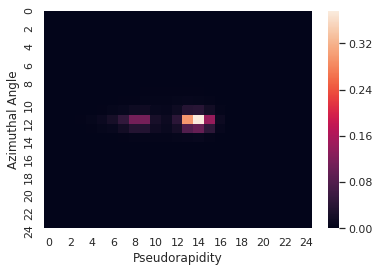

In [12]:
mean_signal_matrix = mean_signal.values
print(mean_signal_matrix.shape)
mean_signal_matrix = mean_signal_matrix.reshape((25,25))

print_heatmap(mean_signal_matrix)

We then add a last column, with the value of `1`. This last column classify this data as signal data. After creating the full dataset we will rename this column to _class_.

In [13]:
signal_data[625] = 1

In [14]:
signal_data.iloc[0:10,625]

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: 625, dtype: int64

After preprocessing the _signal_ data, we will perform the same steps with the _background_ data.

In [15]:
!wget -c https://github.com/raphaelmcobe/jet-classification/raw/master/background_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt

--2020-02-20 15:32:01--  https://github.com/raphaelmcobe/jet-classification/raw/master/background_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt
Resolvendo github.com (github.com)... 18.228.67.229
Conectando-se a github.com (github.com)|18.228.67.229|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 302 Found
Localização: https://raw.githubusercontent.com/raphaelmcobe/jet-classification/master/background_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt [redirecionando]
--2020-02-20 15:32:02--  https://raw.githubusercontent.com/raphaelmcobe/jet-classification/master/background_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt
Resolvendo raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.252.133
Conectando-se a raw.githubusercontent.com (raw.githubusercontent.com)|151.101.252.133|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 416 Range Not Satisfiable

    O arquivo já foi completamente obtido; não há nada a ser feito.



In [16]:
backgroud_data = pd.read_table('background_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt', header=None, dtype=np.float32)
print(backgroud_data.shape)

(11298, 626)


In [17]:
backgroud_data.drop(625, axis=1, inplace=True)
print(backgroud_data.shape)

(11298, 625)


In [18]:
mean_background = backgroud_data.mean()
print(mean_background.iloc[1:10,])

1    0.000000e+00
2    0.000000e+00
3    8.339239e-08
4    0.000000e+00
5    1.226879e-06
6    9.698673e-07
7    3.696426e-06
8    8.896710e-06
9    5.325904e-06
dtype: float32


(625,)
AxesSubplot(0.125,0.125;0.62x0.755)


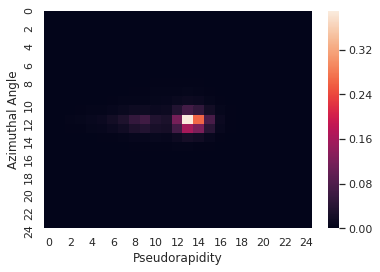

In [19]:
mean_background_matrix = mean_background.values
print(mean_background_matrix.shape)
mean_background_matrix = mean_background_matrix.reshape((25,25))

print_heatmap(mean_background_matrix)

We modify this data, to point out that this is the background data, by setting the last column to `0`.

In [20]:
backgroud_data[625] = 0

In [21]:
backgroud_data.iloc[0:10,625]

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: 625, dtype: int64

Now we concatenate the data and shuffle it in order to randomize its columns.

In [22]:
frames = [signal_data, backgroud_data]
full_data = pd.concat(frames)

In [23]:
full_data = full_data.sample(frac=1).reset_index(drop=True)
full_data.rename(columns={625:'class'}, inplace=True)

Now let's examine how our data looks like.

In [24]:
from IPython.core.display import display
with pd.option_context('display.max_rows', 200, 'display.max_columns', 15, 
                       'display.float_format', '{:.2f}'.format):
    display(full_data)

,0,1,2,3,4,5,6,...,619,620,621,622,623,624,class
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22591,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
22592,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
22593,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
22594,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0


# Defining and Training the model

Split the full dataset into _test_ and _train_ data in a 70-30% rate.

In [25]:
train_data, test_data = train_test_split(full_data, test_size = 0.3)
print(train_data.shape)

print(test_data.shape)

(15817, 626)
(6779, 626)


The _Keras_ framework, in order to train its network must receive the dependent and independent variables in  separated tables.

In [26]:
X_train = train_data.iloc[:, :-1]
print(X_train.shape)
Y_train = train_data.iloc[:,-1:]
print(Y_train.shape)

(15817, 625)
(15817, 1)


In [27]:
X_test = test_data.iloc[:, :-1]
print(X_test.shape)
Y_test = test_data.iloc[:,-1:]
print(Y_test.shape)

(6779, 625)
(6779, 1)


We must convert the dependent variable to be a probability distribution of the possible outcomes, thus, a value of output `1` must become the probabilities `(0, 1)`. Conversely, a `0` outcome value must become the pair `(1, 0)`.

In [28]:
Y_train = to_categorical(Y_train.values, num_classes=2)

## Neural Network Architecture Definition

We defined a simple NN, with only two hidden layer.

In [30]:
dimof_input = X_train.shape[1]
model = Sequential()
model.add(Dense(units=400, activation='relu', input_dim=dimof_input))
model.add(Dropout(0.1))
model.add(Dense(units=210, activation='elu', input_dim=dimof_input))
model.add(Dropout(0.1))
model.add(Dense(units=105, activation='elu', input_dim=dimof_input))
model.add(Dropout(0.1))
model.add(Dense(units=50, activation='elu', input_dim=dimof_input))
model.add(Dropout(0.1))
model.add(Dense(units=25, activation='elu', input_dim=dimof_input))
model.add(Dropout(0.1))
model.add(Dense(units=12, activation='elu', input_dim=dimof_input))
model.add(Dropout(0.1))
model.add(Dense(units=6, activation='elu', input_dim=dimof_input))
model.add(Dropout(0.1))
model.add(Dense(units=2))
model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', 
              metrics=["accuracy"])

After defining the NN architecture we train it using the `fit` method. We trained it for 50 epochs (backpropagation cycles). 

In [31]:
model.fit(X_train.values, Y_train, batch_size=128, epochs=350, verbose=1)

Train on 15817 samples
Epoch 1/350
15817/15817 [==============================] - 3s 160us/sample - loss: 0.1095 - accuracy: 0.6750
Epoch 2/350
15817/15817 [==============================] - 0s 31us/sample - loss: 0.0934 - accuracy: 0.7336
Epoch 3/350
15817/15817 [==============================] - 0s 32us/sample - loss: 0.0878 - accuracy: 0.7506
Epoch 4/350
15817/15817 [==============================] - 1s 32us/sample - loss: 0.0822 - accuracy: 0.7689
Epoch 5/350
15817/15817 [==============================] - 1s 32us/sample - loss: 0.0793 - accuracy: 0.7782
Epoch 6/350
15817/15817 [==============================] - 0s 32us/sample - loss: 0.0751 - accuracy: 0.7899
Epoch 7/350
15817/15817 [==============================] - 1s 32us/sample - loss: 0.0710 - accuracy: 0.8039
Epoch 8/350
15817/15817 [==============================] - 1s 32us/sample - loss: 0.0687 - accuracy: 0.8125
Epoch 9/350
15817/15817 [==============================] - 0s 31us/sample - loss: 0.0667 - accuracy: 0.8178
Epoc

15817/15817 [==============================] - 1s 32us/sample - loss: 0.0215 - accuracy: 0.9501
Epoch 77/350
15817/15817 [==============================] - 0s 31us/sample - loss: 0.0206 - accuracy: 0.9514
Epoch 78/350
15817/15817 [==============================] - 1s 32us/sample - loss: 0.0211 - accuracy: 0.9507
Epoch 79/350
15817/15817 [==============================] - 1s 37us/sample - loss: 0.0215 - accuracy: 0.9493
Epoch 80/350
15817/15817 [==============================] - 1s 32us/sample - loss: 0.0219 - accuracy: 0.9479
Epoch 81/350
15817/15817 [==============================] - 1s 32us/sample - loss: 0.0213 - accuracy: 0.9507
Epoch 82/350
15817/15817 [==============================] - 1s 32us/sample - loss: 0.0213 - accuracy: 0.9504
Epoch 83/350
15817/15817 [==============================] - 1s 34us/sample - loss: 0.0208 - accuracy: 0.9511
Epoch 84/350
15817/15817 [==============================] - 1s 33us/sample - loss: 0.0211 - accuracy: 0.9501
Epoch 85/350
15817/15817 [======

15817/15817 [==============================] - 1s 33us/sample - loss: 0.0136 - accuracy: 0.9695
Epoch 151/350
15817/15817 [==============================] - 1s 32us/sample - loss: 0.0136 - accuracy: 0.9693
Epoch 152/350
15817/15817 [==============================] - 0s 31us/sample - loss: 0.0159 - accuracy: 0.9640
Epoch 153/350
15817/15817 [==============================] - 1s 32us/sample - loss: 0.0140 - accuracy: 0.9681
Epoch 154/350
15817/15817 [==============================] - 1s 33us/sample - loss: 0.0137 - accuracy: 0.9696
Epoch 155/350
15817/15817 [==============================] - 1s 32us/sample - loss: 0.0128 - accuracy: 0.9716
Epoch 156/350
15817/15817 [==============================] - 1s 32us/sample - loss: 0.0130 - accuracy: 0.9715
Epoch 157/350
15817/15817 [==============================] - 0s 31us/sample - loss: 0.0138 - accuracy: 0.9690
Epoch 158/350
15817/15817 [==============================] - 1s 33us/sample - loss: 0.0135 - accuracy: 0.9696
Epoch 159/350
15817/1581

15817/15817 [==============================] - 1s 35us/sample - loss: 0.0105 - accuracy: 0.9771
Epoch 225/350
15817/15817 [==============================] - 1s 35us/sample - loss: 0.0103 - accuracy: 0.9776
Epoch 226/350
15817/15817 [==============================] - 1s 33us/sample - loss: 0.0095 - accuracy: 0.9798
Epoch 227/350
15817/15817 [==============================] - 1s 34us/sample - loss: 0.0103 - accuracy: 0.9769
Epoch 228/350
15817/15817 [==============================] - 0s 31us/sample - loss: 0.0104 - accuracy: 0.9775
Epoch 229/350
15817/15817 [==============================] - 0s 32us/sample - loss: 0.0102 - accuracy: 0.9776
Epoch 230/350
15817/15817 [==============================] - 0s 31us/sample - loss: 0.0100 - accuracy: 0.9781
Epoch 231/350
15817/15817 [==============================] - 0s 32us/sample - loss: 0.0099 - accuracy: 0.9792
Epoch 232/350
15817/15817 [==============================] - 0s 32us/sample - loss: 0.0099 - accuracy: 0.9786
Epoch 233/350
15817/1581

15817/15817 [==============================] - 1s 32us/sample - loss: 0.0103 - accuracy: 0.9771
Epoch 299/350
15817/15817 [==============================] - 0s 31us/sample - loss: 0.0092 - accuracy: 0.9800
Epoch 300/350
15817/15817 [==============================] - 0s 32us/sample - loss: 0.0091 - accuracy: 0.9803
Epoch 301/350
15817/15817 [==============================] - 1s 32us/sample - loss: 0.0090 - accuracy: 0.9809
Epoch 302/350
15817/15817 [==============================] - 0s 32us/sample - loss: 0.0086 - accuracy: 0.9822
Epoch 303/350
15817/15817 [==============================] - 1s 32us/sample - loss: 0.0089 - accuracy: 0.9809
Epoch 304/350
15817/15817 [==============================] - 1s 32us/sample - loss: 0.0085 - accuracy: 0.9823
Epoch 305/350
15817/15817 [==============================] - 1s 35us/sample - loss: 0.0083 - accuracy: 0.9828
Epoch 306/350
15817/15817 [==============================] - 1s 35us/sample - loss: 0.0093 - accuracy: 0.9802
Epoch 307/350
15817/1581

After training the model we need to evaluate it.

In [32]:
Y_test = to_categorical(Y_test.values, num_classes=2)

In [34]:
score = model.evaluate(X_test.values, Y_test, verbose=0)
print(model.metrics_names)
print(score)

['loss', 'accuracy']
[0.12134047379152035, 0.72355807]


Now let's take a look at the missclassified observations.

In [35]:
Y_test_predicted = model.predict(X_test.values, verbose=0)

In [36]:
Y_test_predicted

array([[-0.16617519,  0.97077745],
       [ 0.3973203 ,  0.5004829 ],
       [ 0.9160099 , -0.10879564],
       ...,
       [ 0.992068  , -0.19912088],
       [ 0.99658465, -0.2049672 ],
       [-0.18729049,  0.98346776]], dtype=float32)

Now we calculate the false negatives and also the false positives by comparing the true value with the predicted one.

In [37]:
Y_test_predicted_values = get_predicted_values(Y_test_predicted)
Y_test_values = get_predicted_values(Y_test)
print(Y_test_predicted_values[1:10])
print(Y_test_values[1:10])

false_positives = []
false_negatives = []
for i in range(len(Y_test_values)):
    if Y_test_values[i] == 0 and Y_test_predicted_values[i] == 1:
        false_positives.append(i)
    elif Y_test_values[i] == 1 and Y_test_predicted_values[i] == 0:
        false_negatives.append(i)
        
print("False Positive Rate: {:.2f}".format(len(false_positives)/len(Y_test_values)))
print("False Negative Rate: {:.2f}".format(len(false_negatives)/len(Y_test_values)))

[1, 0, 1, 1, 1, 0, 0, 0, 1]
[0, 1, 1, 1, 1, 0, 0, 0, 1]
False Positive Rate: 0.15
False Negative Rate: 0.13


And try to visualize the heatmaps for false positives and negatives. Firstly the false negatives, where the network was supposed to answer _Signal_, but instead, it answered _Background_.

[10, 11, 28, 35, 37, 44, 46, 53, 59]
(880, 625)
(625,)
AxesSubplot(0.125,0.125;0.62x0.755)


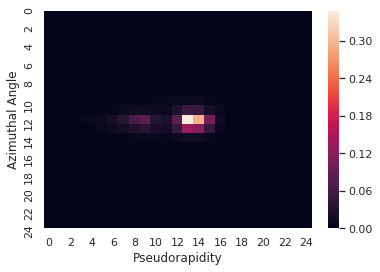

In [38]:
print(false_negatives[1:10])
false_negatives_values = X_test.iloc[false_negatives,]
print(false_negatives_values.shape)

mean_false_negatives = false_negatives_values.mean().values
print(mean_false_negatives.shape)
mean_false_negatives = mean_false_negatives.reshape((25,25))

print_heatmap(mean_false_negatives)

Then we examine the cases in which the network should have responded _Background_, but it answered _Signal_.

[12, 18, 32, 34, 38, 47, 54, 63, 65]
(994, 625)
(625,)
AxesSubplot(0.125,0.125;0.62x0.755)


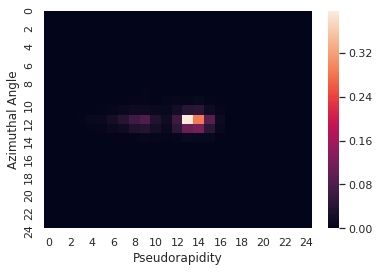

In [39]:
print(false_positives[1:10])
false_positives_values = X_test.iloc[false_positives,]
print(false_positives_values.shape)

mean_false_positives = false_positives_values.mean().values
print(mean_false_positives.shape)
mean_false_positives = mean_false_positives.reshape((25,25))

print_heatmap(mean_false_positives)